<a href="https://colab.research.google.com/github/MustafaKhan670093/Machine-Learning-Playbook/blob/master/ResNets_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ResNets From Scratch**

**[Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)** was introduced in 2015 by researchers at Microsoft. The main question the authors asked was: 

> ### **Is learning better networks as easy as stacking more layers?**

The short answer: No. Enter: Resnets.

The main takeaway from the paper is:

*   ***Deeper*** neural networks are more difficult to train.
*  When deeper networks are able to start converging, a ***degradation problem*** occurs: with the network
depth increasing, accuracy gets saturated and then degrades rapidly. 
  * Unexpectedly, this degredation is ***not caused by overfitting***.
  * Adding ***more layers*** to a ***suitably deep model*** leads to ***higher training error***.
* Finally, ***skip connections*** overcome this problem by providing a new pathway for the gradients to flow.



## **The Nature Of Deep Networks**

Let us consider a shallower architecture and its deeper counterpart that adds
more layers onto it. 
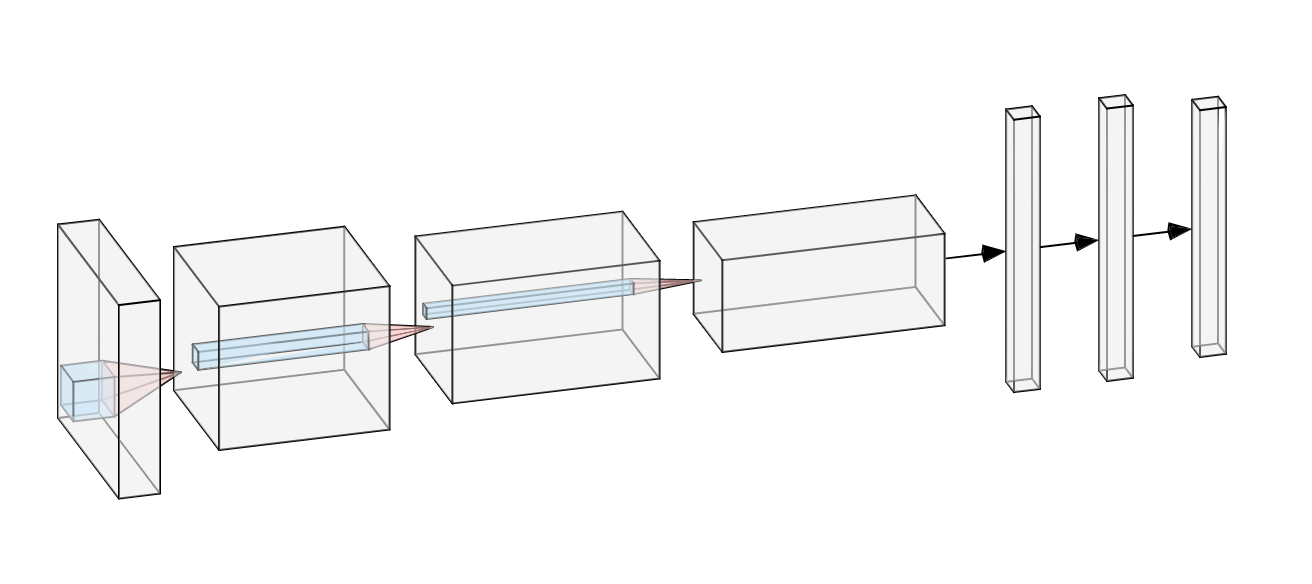

<p><center>Shallow architecture.</center></p>

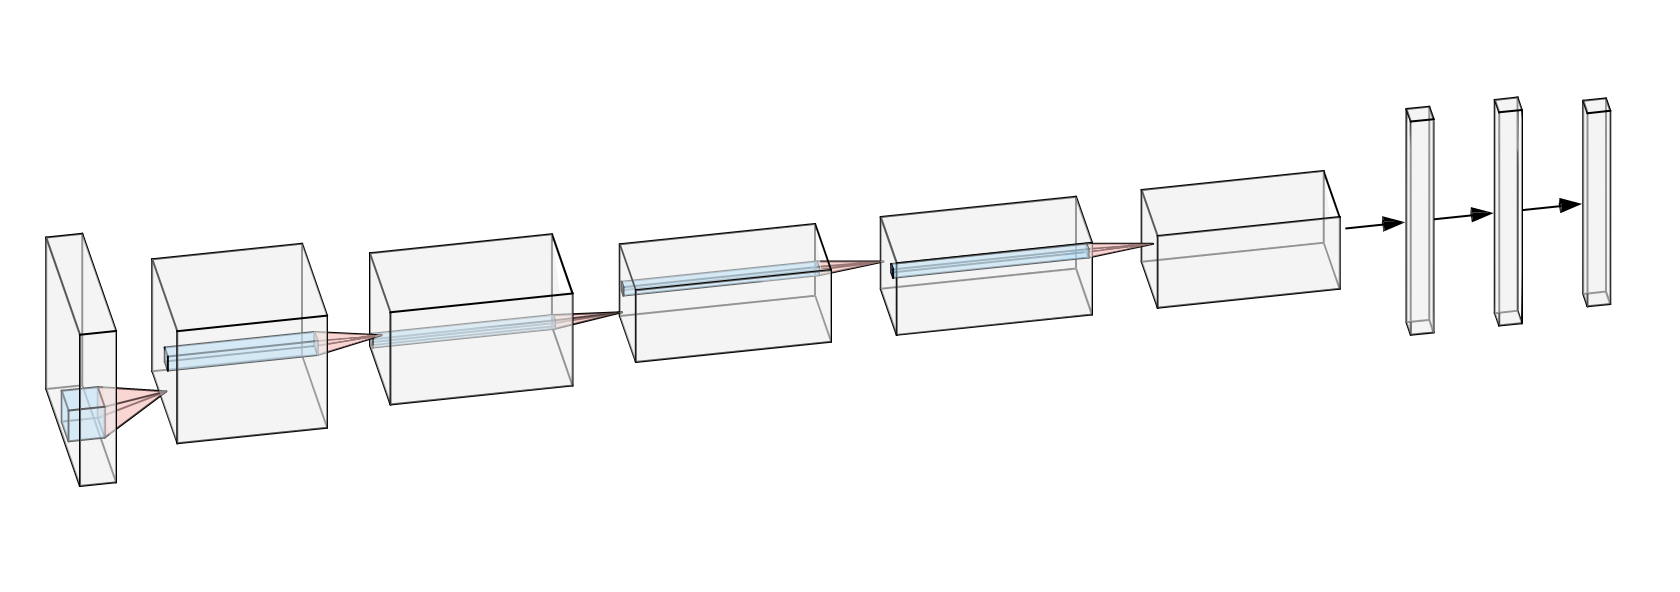

<p><center>Deeper architecture.</center></p>

Assuming that the shallower network is the optimal depth in order to achieve good performance, what sort of solution will the deeper network with more layers learn?

There exists a solution ***by construction*** to the deeper model: the (two) added layers (shown above) would have to be identity mappings, and the other layers would be copied from the learned shallower model. ***The existence of this constructed solution indicates that a deeper model should produce no higher training error than its shallower counterpart.*** Mathematically, if the cost function we are minimizing is as follows with $x_i$ being the input and $x_o$ being the output of the NN:

\begin{align}
\min |x_i - x_o|^2
\end{align}

Then, the weights per layer (ignoring activation functions, normalization, etc. to keep the analysis simple) is the following where $W_1$ are the weights of layer $1$ and $W_n$ are the weights of layer $n$:

\begin{align}
x_o = W_n(W_{n-1}(...(W_2(W_1(x_i)))))
\end{align}

Clearly, if the two extra layers in the deeper network are superfluous then $W_n$ and $W_{n-1}$ should be equal to $I$ (the identity matrix).

So, does this happen in practice? Experiments show that our current solvers are unable to find solutions that are comparably good or better than the constructed solution (or unable to do so in feasible time). So how do we work around this? Well, before we go on, let's try to think of why this might be happening. What mapping do you think is going to be easier to learn for a network?

\begin{align}
\begin{bmatrix}
    0.005 & \dots  & 0.04 \\
    \vdots & \ddots & \vdots \\
    0.024 &\dots  & 0.007
\end{bmatrix} \Longrightarrow
\begin{bmatrix}
    1 & \dots  & 0 \\
    \vdots & \ddots & \vdots \\
    0 &\dots  & 1
\end{bmatrix}
\end{align} 

or
\begin{align}
\begin{bmatrix}
    0.005 & \dots  & 0.04 \\
    \vdots & \ddots & \vdots \\
    0.024 &\dots  & 0.007
\end{bmatrix} \Longrightarrow
\begin{bmatrix}
    0 & \dots  & 0 \\
    \vdots & \ddots & \vdots \\
    0 &\dots  &0
\end{bmatrix}
\end{align} 

When weights are randomly initialized or go through a network, intuitively, it seems easier for a network to zero out these weights as opposed to learning an identity mapping. Why is this useful to realize? Well, instead of hoping each few stacked layers directly fit a desired underlying mapping, the authors explicitly let these layers fit a residual mapping:

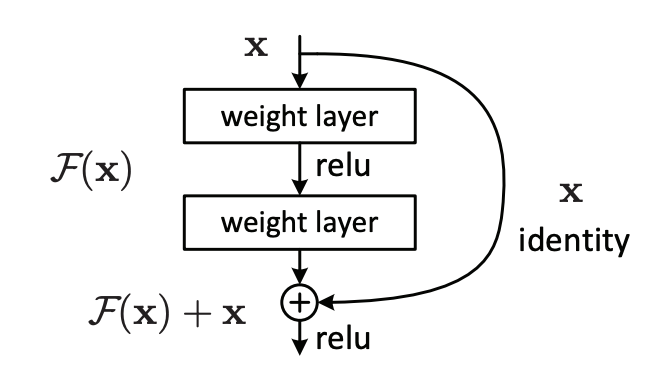


The original mapping is recast into $F(x)+x$ and so when $F(x) \rightarrow 0$, the network simply has the same input (downsampled if needed) passed as an output. This might seem redundant, however, once we remember that as ML researchers and engineers we don't know at what depth a network will successfully converge to the best solution, it makes sense to try deeper network architectures, which have a greater caapacity to learn features in data, and then use these residual mappings as a failsafe to avoid the degredation problem.

## **Summary Of Advantages Of Resnets**

*   The formulation of $F(x) + x$ can be realized by feedforward neural networks with “shortcut connections”.
*   Identity shortcut connections add neither extra parameter nor computational complexity. The entire network can still be trained
end-to-end by SGD with backpropagation, and can be easily implemented using common libraries without modifying the solvers.
* Deep residual nets can easily enjoy accuracy gains from greatly increased depth without the worry of the degradation problem, producing results substantially better than previous networks.



# **Pytorch Implementation Of Residual Layers**

In the original ResNet paper, there were two building blocks for residual neural networks. Networks of depth 18 and 34 used a Basic Block but deeper networks of depth 50, 101 and 152 were reccomended to use a Bottleneck Building Block. Both are shown and then implemented below.

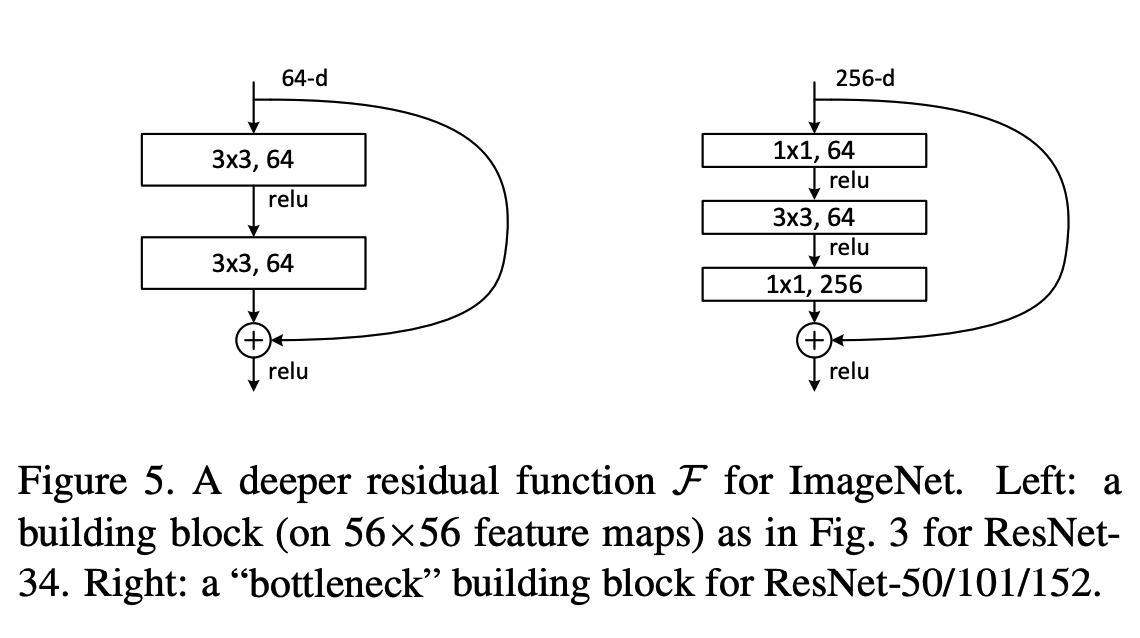

### **Imports**

In [1]:
import torch
from torch import nn

### **Defining The BasicBlock And The BottleneckBlock**

In [2]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels))
        else:
            self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        shortcut = self.shortcut(x)
        x = nn.ReLU()(self.bn(self.conv_1(x)))
        x = nn.ReLU()(self.bn(self.conv_2(x)))
        x = x + shortcut
        return nn.ReLU()(x)

In [3]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        self.downsample = downsample
        self.conv_1 = nn.Conv2d(in_channels, out_channels//4, kernel_size=1, stride=1)
        self.conv_2 = nn.Conv2d(out_channels//4, out_channels//4, kernel_size=3, stride=2 if downsample else 1, padding=1)
        self.conv_3 = nn.Conv2d(out_channels//4, out_channels, kernel_size=1, stride=1)

        if self.downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2 if self.downsample else 1),
                nn.BatchNorm2d(out_channels))
        else:
            self.shortcut = nn.Sequential()

        self.bn_1 = nn.BatchNorm2d(out_channels//4)
        self.bn_2 = nn.BatchNorm2d(out_channels//4)
        self.bn_3 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        shortcut = self.shortcut(x)
        x = nn.ReLU()(self.bn_1(self.conv_1(x)))
        x = nn.ReLU()(self.bn_2(self.conv_2(x)))
        x = nn.ReLU()(self.bn_3(self.conv_3(x)))
        x = x + shortcut
        return nn.ReLU()(x)

### **The ResNet Architecture Class**

In [4]:
class ResNet(nn.Module):
    def __init__(self, in_channels, resblock, repeat, use_bottleneck=False, outputs=1000):
        super().__init__()
        self.layer_0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())

        if use_bottleneck:
            filters = [64, 256, 512, 1024, 2048]
        else:
            filters = [64, 64, 128, 256, 512]

        self.layer_1 = nn.Sequential()
        self.layer_1.add_module('conv2_1', resblock(filters[0], filters[1], downsample=False))
        for i in range(1, repeat[0]):
                self.layer_1.add_module('conv2_%d'%(i+1,), resblock(filters[1], filters[1], downsample=False))

        self.layer_2 = nn.Sequential()
        self.layer_2.add_module('conv3_1', resblock(filters[1], filters[2], downsample=True))
        for i in range(1, repeat[1]):
                self.layer_2.add_module('conv3_%d' % (
                    i+1,), resblock(filters[2], filters[2], downsample=False))

        self.layer_3 = nn.Sequential()
        self.layer_3.add_module('conv4_1', resblock(filters[2], filters[3], downsample=True))
        for i in range(1, repeat[2]):
            self.layer_3.add_module('conv2_%d' % (
                i+1,), resblock(filters[3], filters[3], downsample=False))

        self.layer_4 = nn.Sequential()
        self.layer_4.add_module('conv5_1', resblock(filters[3], filters[4], downsample=True))
        for i in range(1, repeat[3]):
            self.layer_4.add_module('conv3_%d'%(i+1,),resblock(filters[4], filters[4], downsample=False))

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(filters[4], outputs)

    def forward(self, x):
        x = self.layer_0(x)
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.gap(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)

        return x

Finally, we can use these building blocks along with this table from the original paper to construct ResNet-18/34/50/101/152.

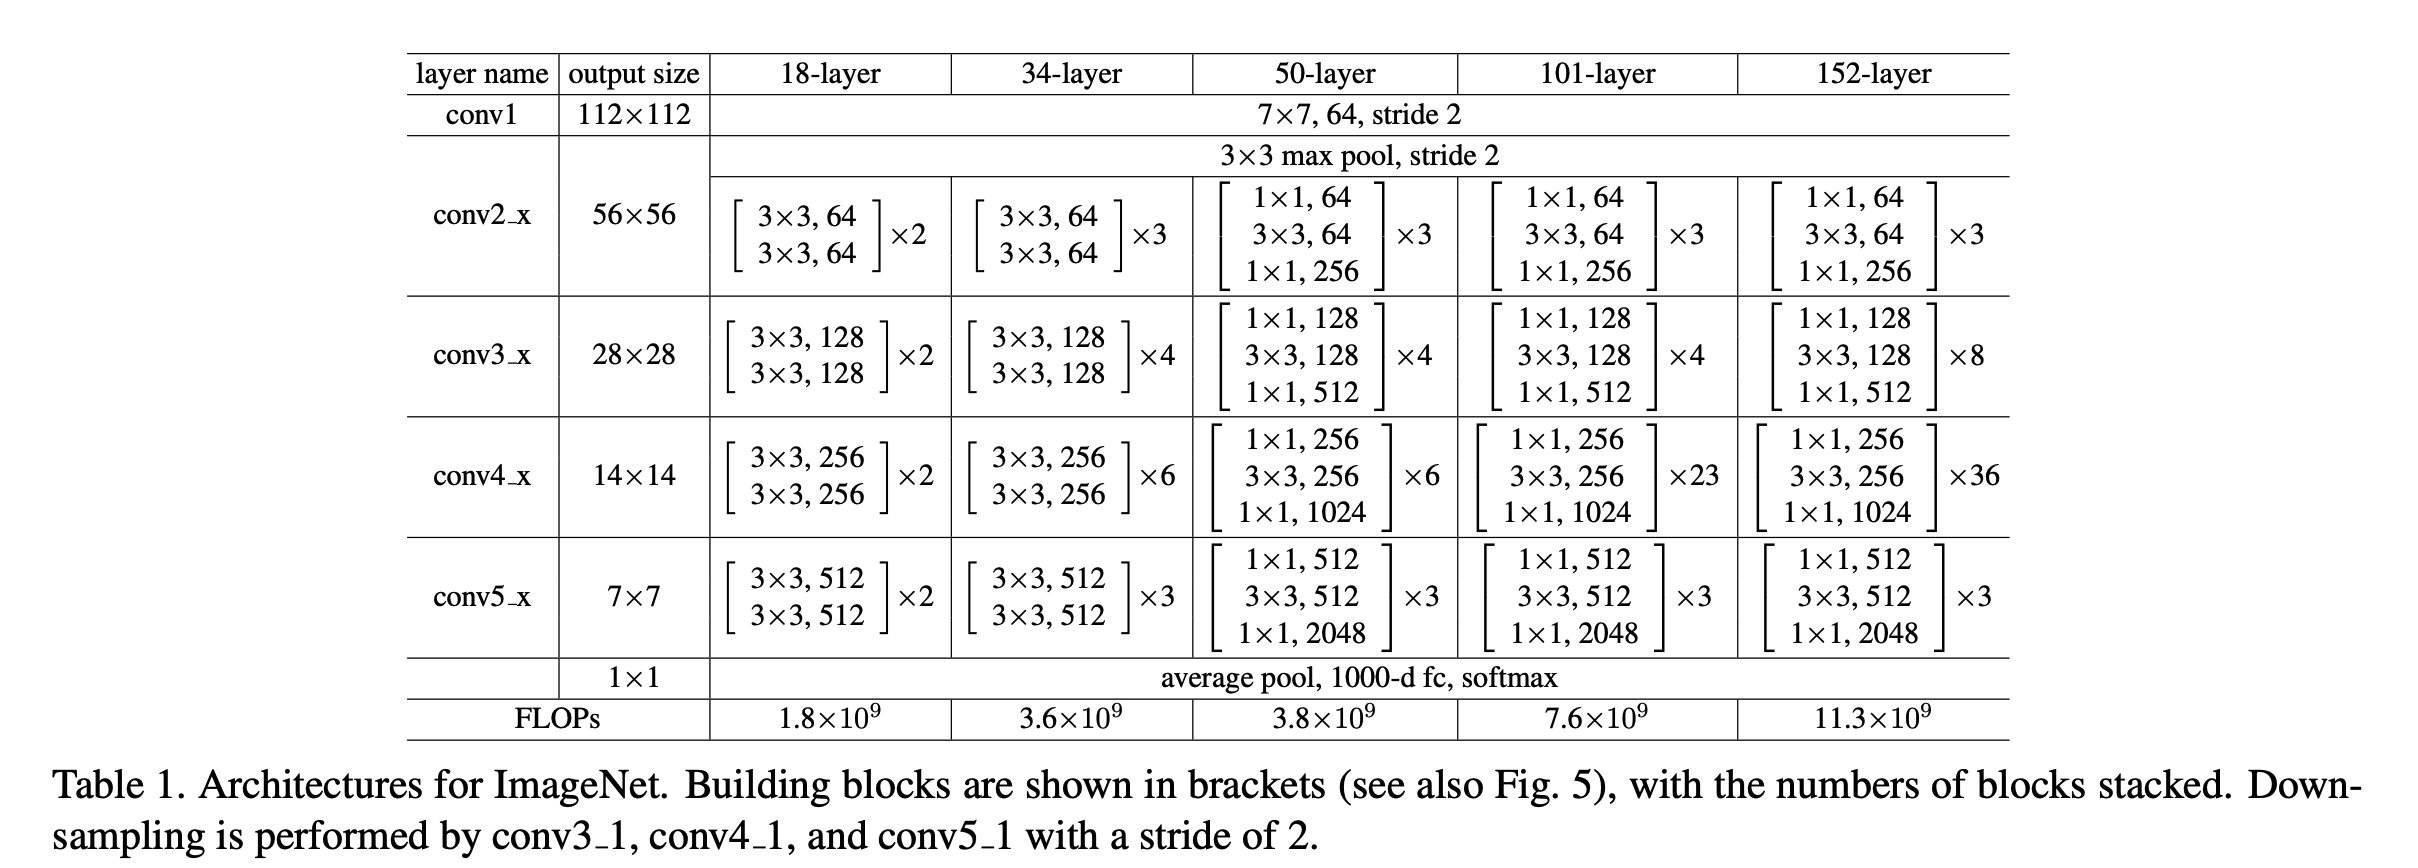

In [5]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The ML code in this project will be trained on " + str(device))

The ML code in this project will be trained on cuda


Note: ResNets were originally trained on imagenet which is why there should be 1000 classes/output nodes in the neural network. However, below I initialize the networks with an ouput of 10, that's because I later test if the ResNet trains on CIFAR-10 which has 10 classes.

In [ ]:
resnet_18 = ResNet(3, BasicBlock, [2, 2, 2, 2], use_bottleneck=False, outputs=10)
resnet_18.to(device)

In [ ]:
resnet_34 = ResNet(3, BasicBlock, [3, 4, 6, 3], use_bottleneck=False, outputs=10)
resnet_34.to(device)

In [ ]:
resnet_50 = ResNet(3, BottleneckBlock, [3, 4, 6, 3], use_bottleneck=True, outputs=10)
resnet_50.to(device)

In [ ]:
resnet_101 = ResNet(3, BottleneckBlock, [3, 4, 23, 3], use_bottleneck=True, outputs=10)
resnet_101.to(device)

In [ ]:
resnet_152 = ResNet(3, BottleneckBlock, [3, 8, 36, 3], use_bottleneck=True, outputs=10)
resnet_152.to(device)

### **A More Detailed Look At The Architectures**

In [11]:
models = [resnet_18, resnet_34, resnet_50, resnet_101, resnet_152]
model_names = ["resnet_18", "resnet_34", "resnet_50", "resnet_101", "resnet_152"]

for i in range(len(models)):
  print("Model: ", str(model_names[i]))
  # Find total parameters and trainable parameters
  total_params = sum(p.numel() for p in models[i].parameters())
  print(f'{total_params:,} total parameters exist in the model.')

  total_trainable_params = sum(
      p.numel() for p in models[i].parameters() if p.requires_grad)
  print(f'{total_trainable_params:,} parameters will be trained.\n')

Model:  resnet_18
11,182,602 total parameters exist in the model.
11,182,602 parameters will be trained.

Model:  resnet_34
21,290,762 total parameters exist in the model.
21,290,762 parameters will be trained.

Model:  resnet_50
23,555,082 total parameters exist in the model.
23,555,082 parameters will be trained.

Model:  resnet_101
42,573,322 total parameters exist in the model.
42,573,322 parameters will be trained.

Model:  resnet_152
58,240,010 total parameters exist in the model.
58,240,010 parameters will be trained.



### **Testing If ResNet Architecture Is Trainable**

**Imports**

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import torch
import numpy as np
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

**Load CIFAR Dataset**

In [ ]:
# number of subproccesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training data to be used as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# choose the training and test datasets
train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders(combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

**Visualize A Batch Of Training Data**

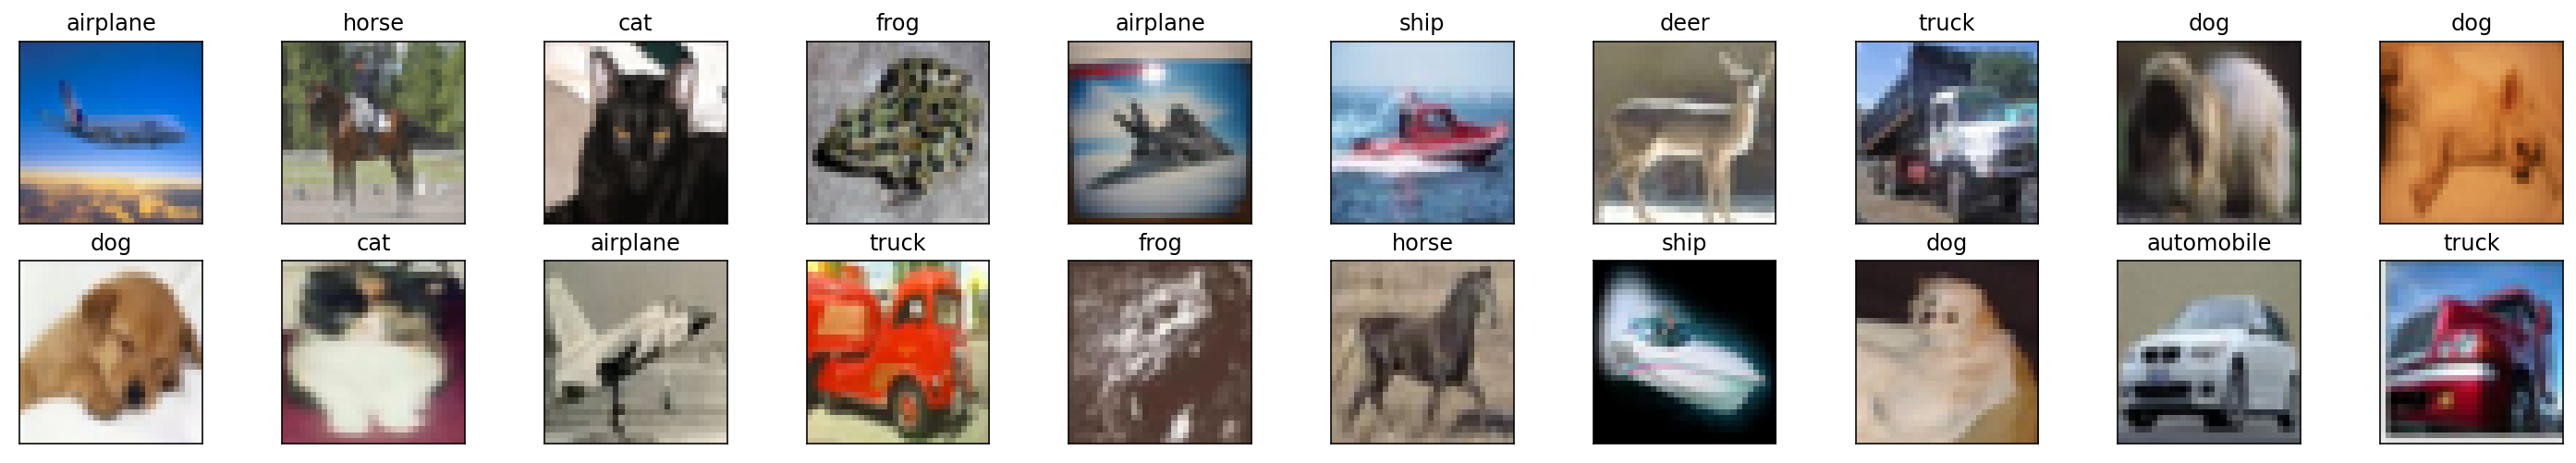

In [14]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

**Initialize Model, Optimizer And Loss Function**

In [15]:
# initialize the CNN
model = resnet_152
               
#Sending model to CPU/GPU
model.to(device);

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)

**Training Model**

In [16]:
n_epochs = 100
epochs_no_improve = 0
n_epochs_stop = 5

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # move data and target tensors to the default device
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        #The next line of code resolved the following error: RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn
        # loss.requires_grad = True    If you don't get the error, comment out this line.
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        # move data and target tensors to the default device
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
        epochs_no_improve = 0
    
    else:
        epochs_no_improve += 1
        # Check early stopping condition
        if epochs_no_improve == n_epochs_stop:
            print('Early stopping!')
            break

Epoch: 1 	Training Loss: 2.139069 	Validation Loss: 2.422608
Validation loss decreased (inf --> 2.422608).  Saving model ...
Epoch: 2 	Training Loss: 1.820020 	Validation Loss: 2.039746
Validation loss decreased (2.422608 --> 2.039746).  Saving model ...
Epoch: 3 	Training Loss: 1.664580 	Validation Loss: 2.062812
Epoch: 4 	Training Loss: 1.549337 	Validation Loss: 1.783498
Validation loss decreased (2.039746 --> 1.783498).  Saving model ...
Epoch: 5 	Training Loss: 1.443350 	Validation Loss: 1.750945
Validation loss decreased (1.783498 --> 1.750945).  Saving model ...
Epoch: 6 	Training Loss: 1.347045 	Validation Loss: 1.672982
Validation loss decreased (1.750945 --> 1.672982).  Saving model ...
Epoch: 7 	Training Loss: 1.262389 	Validation Loss: 1.358683
Validation loss decreased (1.672982 --> 1.358683).  Saving model ...
Epoch: 8 	Training Loss: 1.183602 	Validation Loss: 1.280840
Validation loss decreased (1.358683 --> 1.280840).  Saving model ...
Epoch: 9 	Training Loss: 1.109125 

**Load Model With Best Weights**

In [17]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

**Test Trained Network**

In [18]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # move data and target tensors to the default device
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no more training examples left)' % (class_total[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.668363

Test Accuracy of     0: 83% (4152/5000)
Test Accuracy of     1: 88% (4426/5000)
Test Accuracy of     2: 60% (3012/5000)
Test Accuracy of     3: 73% (3651/5000)
Test Accuracy of     4: 70% (3515/5000)
Test Accuracy of     5: 77% (3854/5000)
Test Accuracy of     6: 90% (4515/5000)
Test Accuracy of     7: 86% (4339/5000)
Test Accuracy of     8: 86% (4334/5000)
Test Accuracy of     9: 85% (4286/5000)

Test Accuracy (Overall): 80% (40084/50000)


**Visualize Sample Test Results**

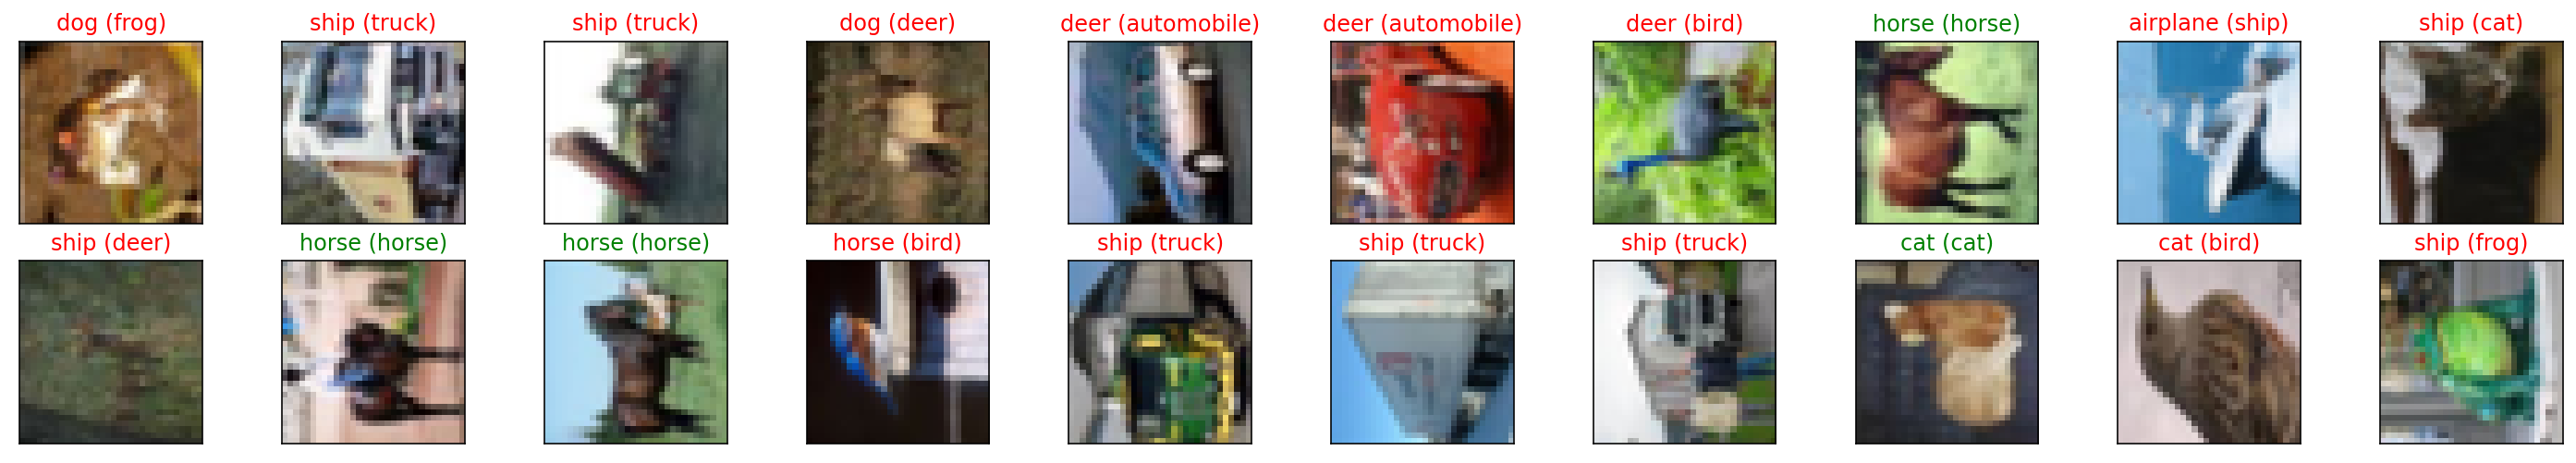

In [20]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

#The following two lines of code avoid clipping input data by normalizing the images first
images -= images.min()
images /= images.max()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.cpu().data.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx]), )
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))